In [190]:
%reset -f

# Importing data

Data has been stored in local using aws cli. 

In [191]:
import logging
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

DATA_PATH = "/home/alejandro/Zrive"

abandoned_carts_df = pd.read_parquet(os.path.join(DATA_PATH, 'abandoned_carts.parquet'))
inventory_df = pd.read_parquet(os.path.join(DATA_PATH, 'inventory.parquet'))
orders_df = pd.read_parquet(os.path.join(DATA_PATH, 'orders.parquet'))
regulars_df = pd.read_parquet(os.path.join(DATA_PATH, 'regulars.parquet'))
users_df = pd.read_parquet(os.path.join(DATA_PATH, 'users.parquet'))

logging.basicConfig(level=logging.debug, format='%(asctime)s - %(levelname)s - %(message)s')


def printmd(string):
    display(Markdown(string))

# Part 1

The data is partitioned over multiple dataset and comes from a groceries ecommerce
platform selling products directly to consumers (think of it as an online
supermarket):

**orders.parquet**: An order history of customers. Each row is an order and the
item_ids for the order are stored as a list in the item_ids column

**regulars.parquet**: Users are allowed to specify items that they wish to buy
regularly. This data gives the items each user has asked to get regularly, along
with when they input that information.

**abandoned_cart.parquet**: If a user has added items to their basket but not
bought them, we capture that information. Items that were abandoned are stored
as a list in item_ids.

**inventory.parquet**: Some information about each item_id

**users.parquet**: Information about users.

In [192]:
# Quick check on each dataset to understand their structure and identify potential issues
datasets = {
    "Abandoned Carts": abandoned_carts_df,
    "Inventory": inventory_df,
    "Orders": orders_df,
    "Regulars": regulars_df,
    "Users": users_df
}

# Displaying the first few rows of each dataset and their info to identify potential issues
for name, df in datasets.items():
    printmd(f"# Dataset: {name}")
    display(df.head())
    df.info()
    print("\nMising values(NAs):")
    display(df.isna().sum())


# Dataset: Abandoned Carts

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB

Mising values(NAs):


id            0
user_id       0
created_at    0
variant_id    0
dtype: int64

# Dataset: Inventory

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB

Mising values(NAs):


variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

# Dataset: Orders

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB

Mising values(NAs):


id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64

# Dataset: Regulars

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB

Mising values(NAs):


user_id       0
variant_id    0
created_at    0
dtype: int64

# Dataset: Users

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB

Mising values(NAs):


user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64

## Check Orders

With the orders dataframe, we could try to identify the purchasing patterns of customers. Both, the number of orders per user and the number of items per order are important metrics to understand the purchasing patterns of customers. 



Let's first check the frequency of orders per user.

count    4983.000000
mean        1.760586
std         1.936537
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: order_count, dtype: float64

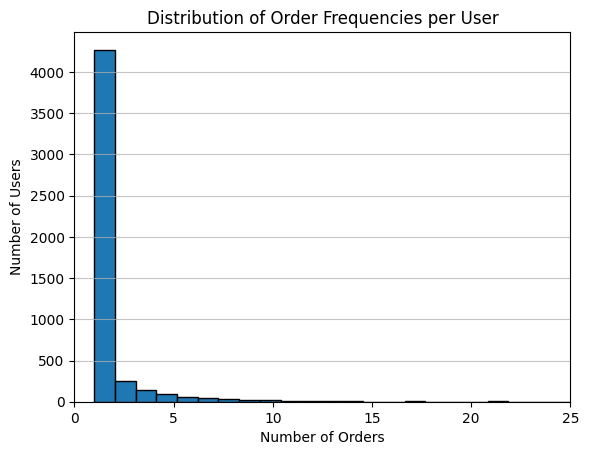

In [196]:
orders_frequency = orders_df['user_id'].value_counts().reset_index()
orders_frequency.columns = ['user_id', 'order_count']
display(orders_frequency['order_count'].describe())
plt.hist(orders_frequency["order_count"],bins = len(orders_frequency["order_count"].unique()), edgecolor="k")
plt.title('Distribution of Order Frequencies per User')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.xlim(min(orders_frequency["order_count"]-1), max(orders_frequency["order_count"]))
plt.grid(axis='y', alpha=0.75)
plt.show()


Most of users just make 1 order, which indicates that the platform has a large base of "one time" users. Let's now check the distribution of order sizes.

count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: order_size, dtype: float64

Most common order size: 10

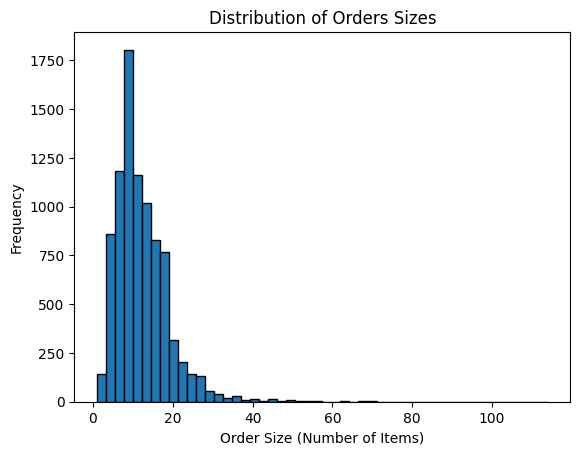

In [197]:
# Calculate order size as the length of the ordered_items list for each order
orders_df['order_size'] = orders_df['ordered_items'].apply(len)
# Analyze the distribution of order sizes
order_size_distribution = orders_df['order_size'].describe()
display(order_size_distribution)
printmd(f"Most common order size: {orders_df['order_size'].mode()[0]}")
plt.hist(orders_df['order_size'], bins=50, edgecolor='k')
plt.title("Distribution of Orders Sizes")
plt.xlabel("Order Size (Number of Items)")
plt.ylabel("Frequency")
plt.show()

As we can see, most orders have 10 items, but there are users who make orders with lots of items creating a long right tail. 
Let's now check the most ordered items. 
As each item has a unique id, we can't know what each item is. However, we can see that all items fall into a specific category, thus ,we can show the most ordered items by mapping its id to its category.

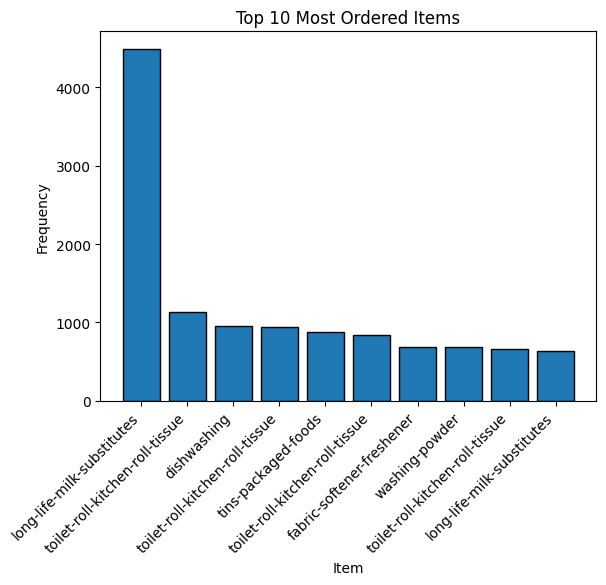

In [198]:
item_frequencies = orders_df.explode('ordered_items')['ordered_items'].value_counts().reset_index()
item_frequencies.columns = ['variant_id', 'item_count']

# merge with inventory to get category information
common_items = pd.merge(item_frequencies, inventory_df, on='variant_id', how='inner')

# plot the top 10 most ordered items
plt.bar(common_items['variant_id'][:10].astype(str),common_items['item_count'][:10],edgecolor='k')
plt.title('Top 10 Most Ordered Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(ticks=range(0,10),labels=common_items['product_type'][:10],rotation=45, ha='right')
plt.show()


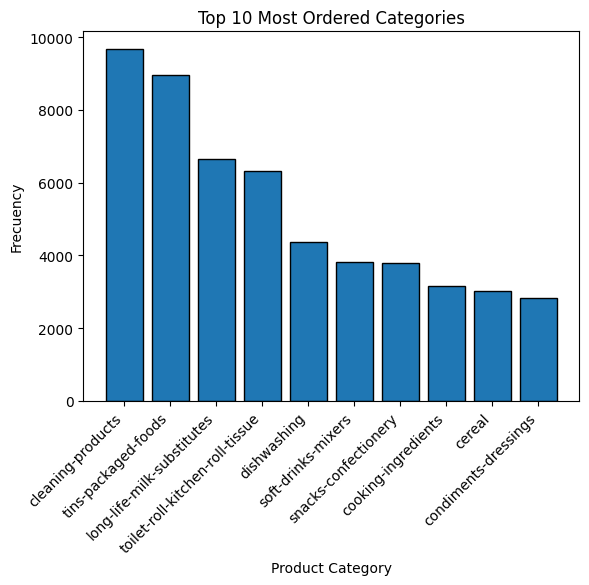

In [199]:
# Determine the most commonly ordered categories
common_categories = common_items.groupby('product_type')['item_count'].sum().reset_index().sort_values('item_count', ascending=False)

plt.bar(x=common_categories['product_type'][:10], height=common_categories['item_count'][:10], edgecolor='k')
plt.title('Top 10 Most Ordered Categories')
plt.xlabel('Product Category')
plt.ylabel('Frecuency')
plt.xticks(rotation=45, ha = 'right')  
plt.show()

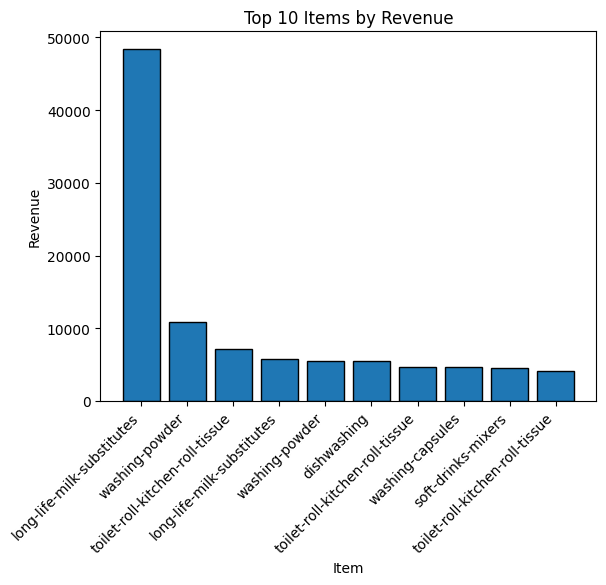

In [204]:
# Determine the items and categories which bring the most revenue
# Calculate the revenue for each item by multiplying the price of each item by the quantity ordered
common_items['revenue'] = common_items['item_count'] * common_items['price']
common_items = common_items.sort_values('revenue', ascending=False)

plt.bar(common_items['variant_id'][:10].astype(str), common_items['revenue'][:10], edgecolor='k')
plt.title('Top 10 Items by Revenue')
plt.xlabel('Item')
plt.ylabel('Revenue')
plt.xticks(ticks=range(0,10),labels=common_items['product_type'][:10],rotation=45, ha='right')
plt.show()



As we can see, the product which produces the most revenue by far, is part of the milk category. This might indicate that the platform relies too much in selling this kind of milk-related product. To check this, let's compare the revenue of the top ten products against the revenue of the rest of the products.

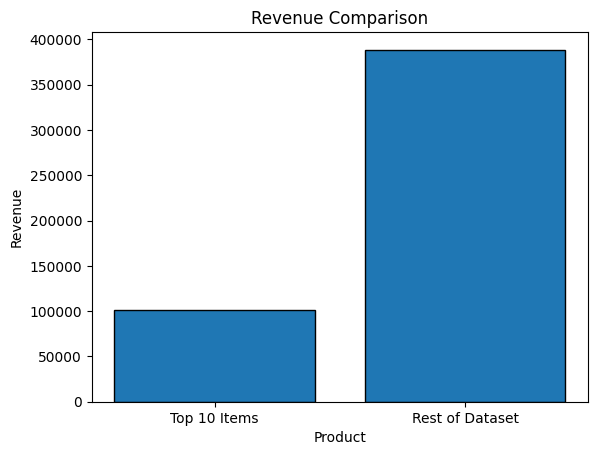

Percentage of revenue from the top 10 items: 20.68%

Percentage of revenue from the rest of the dataset: 79.32%

Percentage of revenue from the top product: 9.88%

In [207]:
# Calculate the total revenue of the rest of the dataset
rest_revenue = common_items['revenue'][10:].sum()

# Create a new dataframe to hold the data for the bar plot
revenue_data = pd.DataFrame({'Product': ['Top 10 Items', 'Rest of Dataset'],
                             'Revenue': [common_items['revenue'][:10].sum(), rest_revenue]})

# Plot the bar chart
plt.bar(revenue_data['Product'], revenue_data['Revenue'], edgecolor='k')
plt.title('Revenue Comparison')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.show()

# Calculate percentage of revenue from the top 10 items
top_10_revenue = common_items['revenue'][:10].sum()
total_revenue = common_items['revenue'].sum()
top_10_revenue_percentage = top_10_revenue / total_revenue * 100
printmd(f"Percentage of revenue from the top 10 items: {top_10_revenue_percentage:.2f}%")
# Calculate percentage of revenue from the rest of the dataset
rest_revenue = common_items['revenue'][10:].sum()
rest_revenue_percentage = rest_revenue / total_revenue * 100
printmd(f"Percentage of revenue from the rest of the dataset: {rest_revenue_percentage:.2f}%")
# Calculate percentage of revenue from the top product 
top_product_revenue = common_items['revenue'][0]
top_product_revenue_percentage = top_product_revenue / total_revenue * 100
printmd(f"Percentage of revenue from the top product: {top_product_revenue_percentage:.2f}%")


The platform's product portfolio doesn't appear to be well balanced in terms of its item revenues, with the top ten products accounting for 20% of the total revenue, while the other 1467 products account for the remaining 80% . Moreover, the top product represents 10% of the total revenue, which is a lot for a single product. Let's now check revenue by general categories.

/tmp/ipykernel_46603/1866416911.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(category_revenue['product_type'],rotation=45, ha='right')
/tmp/ipykernel_46603/1866416911.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(category_revenue['product_type'][:10],rotation=45, ha='right')


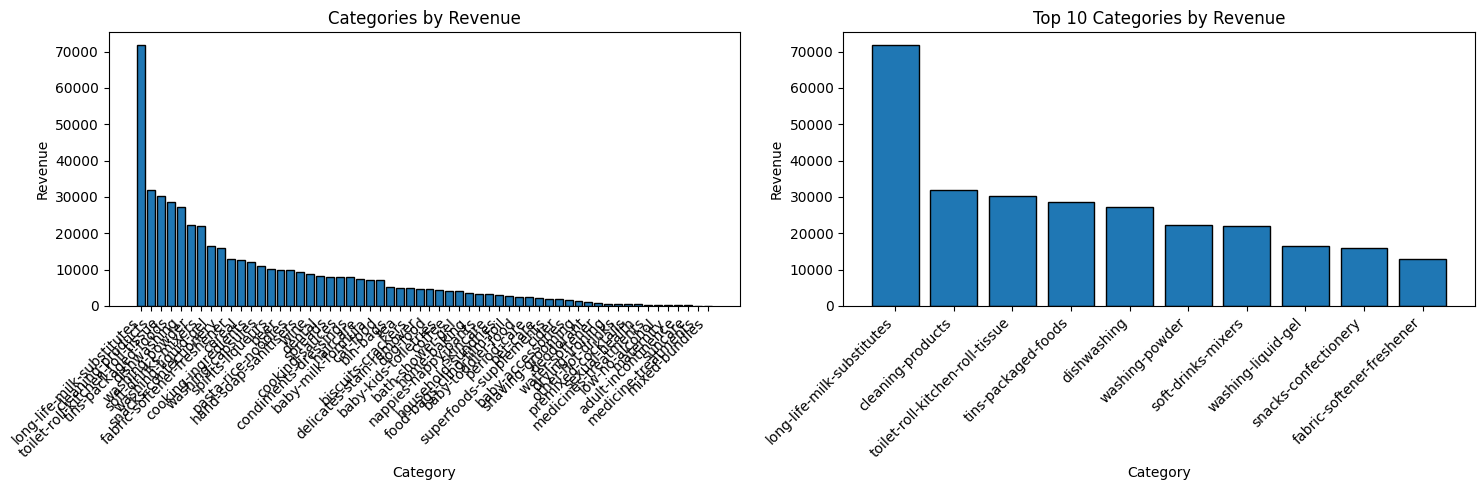

In [222]:
category_revenue = common_items.groupby('product_type')['revenue'].sum().reset_index().sort_values('revenue', ascending=False)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(x=category_revenue['product_type'], height=category_revenue['revenue'], edgecolor='k')
ax[0].set_title('Categories by Revenue')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Revenue')
ax[0].set_xticklabels(category_revenue['product_type'],rotation=45, ha='right')


ax[1].bar(x=category_revenue['product_type'][:10], height=category_revenue['revenue'][:10], edgecolor='k')
ax[1].set_title('Top 10 Categories by Revenue')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Revenue')
ax[1].set_xticklabels(category_revenue['product_type'][:10],rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Check regulars

The regulars analysis can helps us understand customer loyalty and product stickiness by examining which items are consistently purchased and how customers interact with their list of regular purchases.

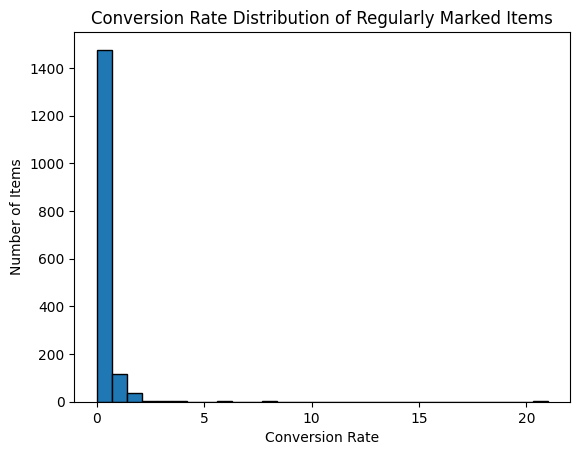

In [231]:
# Count how often each item appears in regulars lists
regulars_frequency = regulars_df['variant_id'].value_counts().reset_index()
regulars_frequency.columns = ['variant_id', 'marked_regular_count']

# Merge the frequencies to compare
regulars_vs_orders = pd.merge(regulars_frequency, item_frequencies, on='variant_id', how='right')
regulars_vs_orders.dropna(inplace=True)

# Calculate conversion rate as the ratio of marked_regular_count to item_ordered
regulars_vs_orders['conversion_rate'] = regulars_vs_orders['marked_regular_count'] / regulars_vs_orders['item_count']


regulars_vs_orders['conversion_rate'].plot.hist(bins=30, edgecolor='k')
plt.title('Conversion Rate Distribution of Regularly Marked Items')
plt.xlabel('Conversion Rate')
plt.ylabel('Number of Items')
plt.show()


In [233]:
# Assuming there's a 'modified_at' column indicating when an item was added to the regulars list
regulars_df['modified_at'] = pd.to_datetime(regulars_df['created_at'])  # Convert to datetime if necessary
regulars_df.sort_values(by=['user_id', 'modified_at'], inplace=True)

# Calculate the difference in days between successive modifications for each user
regulars_df['days_between_updates'] = regulars_df.groupby('user_id')['modified_at'].diff().dt.days

# Aggregate to get average frequency of updates per user
updates_frequency = regulars_df.groupby('user_id')['days_between_updates'].mean().reset_index()
updates_frequency.columns = ['user_id', 'avg_days_between_updates']


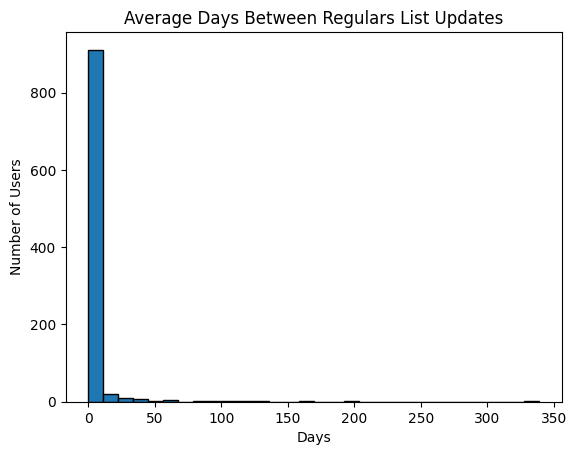

In [234]:
updates_frequency['avg_days_between_updates'].plot.hist(bins=30, edgecolor='k')
plt.title('Average Days Between Regulars List Updates')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.show()


## Check abandoned_carts

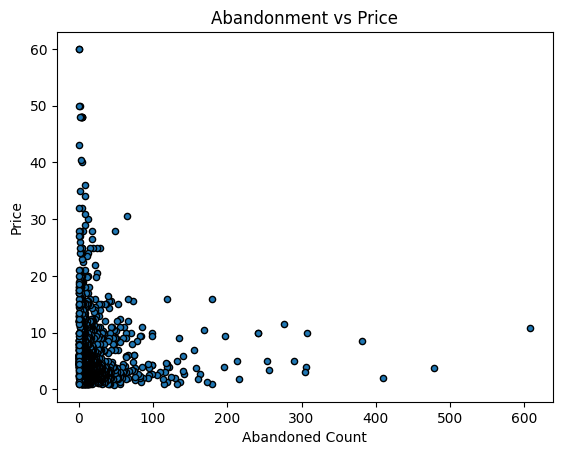

In [237]:
# Count how often each item appears in abandoned carts
abandoned_item_frequency = abandoned_carts_df.explode('variant_id')['variant_id'].value_counts().reset_index()
abandoned_item_frequency.columns = ['variant_id', 'abandoned_count']

# Merge with inventory data to get price and stock level information
abandoned_items_info = pd.merge(abandoned_item_frequency, inventory_df[['variant_id', 'price']], on='variant_id')

# Analyze the relationship between abandonment, price, and stock level
abandoned_items_info.plot.scatter(x='abandoned_count', y='price', edgecolor='k')
plt.title('Abandonment vs Price')
plt.xlabel('Abandoned Count')
plt.ylabel('Price')
plt.show()


In [240]:
# Merge abandoned carts with user demographics
abandoned_carts_users = pd.merge(abandoned_carts_df, users_df, on='user_id', how='left')

# Analyze abandonment rates by demographic groups (e.g., age, location)
abandonment_by_demographics = abandoned_carts_users.groupby(['user_segment', 'user_nuts1'])['variant_id'].count().reset_index()

# Merge abandoned carts data with orders data to examine order history
user_order_history = pd.merge(abandoned_carts_df[['user_id', 'variant_id']], orders_df[['user_id', 'ordered_items']], on='user_id', how='left')

# Calculate abandonment rates for users with different order histories


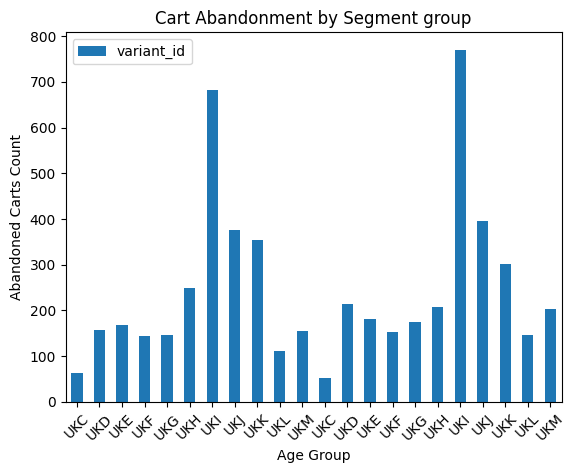

In [244]:
# Assuming abandonment_by_demographics has been calculated
abandonment_by_demographics.plot(kind='bar', x='user_nuts1', y='variant_id', title='Cart Abandonment by Segment group')
plt.xlabel('Age Group')
plt.ylabel('Abandoned Carts Count')
plt.xticks(rotation=45)
plt.show()


## Check inventory and users

In [10]:
inventory_df.info()
display(inventory_df.head())
display(inventory_df.describe())
display(inventory_df.isna().sum())

users_df.info()
display(users_df.head())
display(users_df.describe())
users_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


,variant_id,price,compare_at_price
count,1.733000e+03,1733.000000,1733.000000
mean,3.694880e+13,6.307351,7.028881
std,2.725674e+12,7.107218,7.660542
min,3.361529e+13,0.000000,0.000000
25%,3.427657e+13,2.490000,2.850000
50%,3.927260e+13,3.990000,4.490000
75%,3.948318e+13,7.490000,8.210000
max,4.016793e+13,59.990000,60.000000


variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


,count_people,count_adults,count_children,count_babies,count_pets
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923
std,1.365753,0.869577,1.026246,0.289086,0.995603
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000


user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64